In [347]:
#!g1.1
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.utils.extmath import randomized_svd


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch import utils
from torch.utils.data import TensorDataset, DataLoader

from linearized_nns.estimator import Estimator
from linearized_nns.pytorch_impl.estimators import SgdEstimator
from linearized_nns.pytorch_impl.nns import Myrtle5, Myrtle7, Myrtle10
from linearized_nns.pytorch_impl import ClassifierTraining
from linearized_nns.pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from linearized_nns.pytorch_impl.nns.utils import to_one_hot, print_sizes
from linearized_nns.from_neural_kernels import to_zca, CustomTensorDataset, get_cifar_zca

In [208]:
#!g1.1
DEVICE = 'cuda'
NUM_CLASSES = 200

In [182]:
#!g1.1
def to_zca(train, test, zca_bias=0.0001):
    orig_train_shape = train.shape
    orig_test_shape = test.shape

    train = np.ascontiguousarray(train, dtype=np.float32).reshape(train.shape[0], -1).astype(np.float64)
    test = np.ascontiguousarray(test, dtype=np.float32).reshape(test.shape[0], -1).astype(np.float64)

    n_train = train.shape[0]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]
    test = test - np.mean(test, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)
    test_norms = np.linalg.norm(test, axis=1)

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]
    test = test/test_norms[:,np.newaxis]

    train = torch.to_tensor(train, dtype=torch.double).to(DEVICE)
    train_cov_mat = 1.0/n_train * torch.matmul(train.T, train)

    (E,V) = np.linalg.eig(train_cov_mat)

    E += zca_bias
    sqrt_zca_eigs = np.sqrt(E)
    inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
    global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T)

    train = (train).dot(global_ZCA)
    test = (test).dot(global_ZCA)

    return (train.reshape(orig_train_shape).astype(np.float64), test.reshape(orig_test_shape).astype(np.float64)), global_ZCA

In [183]:
#!g1.1
def get_cifar_zca():
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

    X_train = np.asarray(trainset.data).astype(np.float64)
    y_train = np.asarray(trainset.targets)
    X_test  = np.asarray(testset.data).astype(np.float64)
    y_test  = np.asarray(testset.targets)

    (X_train, X_test), global_ZCA = to_zca(X_train, X_test)

    X_train = np.transpose(X_train, (0,3,1,2))
    X_test  = np.transpose(X_test,  (0,3,1,2))

    return X_train, y_train, X_test, y_test

In [184]:
#!g1.1
%%time
X_train, _, X_test, _ = get_cifar_zca()

Files already downloaded and verified
Files already downloaded and verified


In [185]:
#!g1.1
X_train[0].shape

(3, 32, 32)

In [186]:
X_train[0]

array([[[-1.65183192, -1.91596214, -1.64195516, ...,  1.9336765 ,
          1.67671202,  1.69975139],
        [-2.84610129, -3.39586554, -2.7884646 , ...,  0.78048275,
          0.60957637,  0.45354291],
        [-2.77229456, -2.92845503, -1.82669088, ...,  0.59936793,
          0.62257471,  0.11226297],
        ...,
        [ 3.54200245,  2.91797545,  3.06100934, ...,  1.75178342,
         -1.4082283 , -1.6087027 ],
        [ 2.44707899,  1.93059543,  2.41982469, ...,  2.48208832,
         -0.21615934, -0.92305209],
        [ 2.26081823,  2.02074537,  2.52699937, ...,  3.47745633,
          1.35145709,  0.41484161]],

       [[-1.46052133, -1.89718217, -1.85113785, ...,  0.99272443,
          0.66214103,  0.78690635],
        [-2.68860227, -3.46902367, -3.15061115, ..., -0.35938946,
         -0.61944942, -0.65002576],
        [-2.68388894, -3.17448232, -2.44140125, ..., -0.57843441,
         -0.64878894, -1.06833615],
        ...,
        [ 2.35292974,  1.45741437,  1.5596361 , ...,  

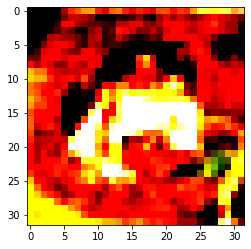

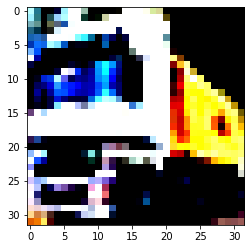

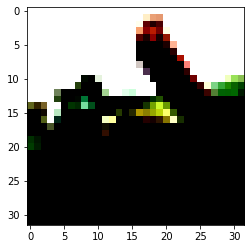

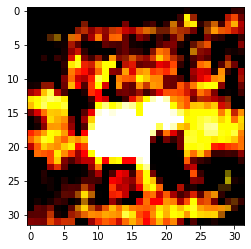

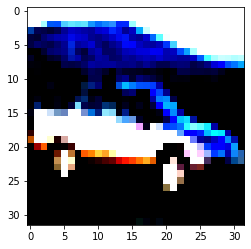

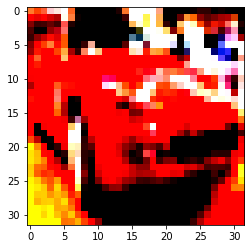

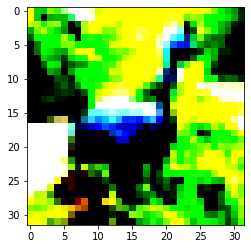

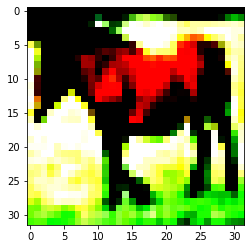

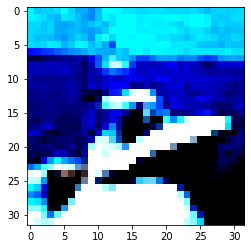

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

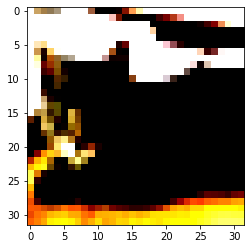

In [187]:
#!g1.1

for i in range(10):
    image = np.transpose(X_train[i], (1,2,0))
    plt.imshow(image)
    plt.show()

In [ ]:
#!g1.1
from sklearn.utils.extmath import randomized_svd

def to_zca_fast(train, test, zca_bias=0.01, n_components=1000):
    print('fast zca')
    orig_train_shape = train.shape
    orig_test_shape = test.shape

    train = np.ascontiguousarray(tracccccckdbvnbfhthicnccrtlnjfdhrfrjkkfnidkrlbl
                                 t, dtype=np.float32).reshape(test.shape[0], -1).astype(np.float64)

    n_train = train.shape[0]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]
    test  =  test - np.mean(test, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)
    test_norms = np.linalg.norm(test, axis=1)

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]
    test = test/test_norms[:,np.newaxis]

    train_torch = torch.tensor(train, dtype=torch.float).to(DEVICE)
    train_cov_mat = 1.0/n_train * torch.matmul(train_torch.T, train_torch).cpu().numpy()
    del train_torch

    U, S, Vt = randomized_svd(train_cov_mat, n_components=n_components)
    
    V = Vt.T
    S += zca_bias
    sqrt_zca_eigs = S
    inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
    global_ZCA = V.dot(inv_sqrt_zca_eigs).dot(V.T)

    train = (train).dot(global_ZCA)
    test = (test).dot(global_ZCA)

    return (train.reshape(orig_train_shape).astype(np.float64), test.reshape(orig_test_shape).astype(np.float64)), global_ZCA

In [316]:
#!g1.1

def to_zca_faster(train, test, zca_bias=0.01, n_components=1000):
    print('faster zca')
    orig_train_shape = train.shape
    orig_test_shape = test.shape

    train = np.ascontiguousarray(train, dtype=np.float32).reshape(train.shape[0], -1).astype(np.float64)
    test  = np.ascontiguousarray(test, dtype=np.float32).reshape(test.shape[0], -1).astype(np.float64)

    n_train = train.shape[0]
    d       = train.shape[1]

    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]
    test  =  test - np.mean(test, axis=1)[:,np.newaxis]

    # Normalize
    train_norms = np.linalg.norm(train, axis=1)
    test_norms  = np.linalg.norm(test, axis=1)

    # Make features unit norm
    train = train/train_norms[:,np.newaxis]
    test  = test/test_norms[:,np.newaxis]
    
    print(train[0])
    
    print('calculating svd...')
    
    _, S, V = randomized_svd(train, n_components=n_components)
    print('svd calculated. applying svd matricies.')
    S = (S ** 2) / n_train + zca_bias
    inv_sqrt_zca_eigs = np.diag(np.power(S, -1))

    train = (train).dot(V.T).dot(inv_sqrt_zca_eigs).dot(V)
    test  =  (test).dot(V.T).dot(inv_sqrt_zca_eigs).dot(V)
    
    print('faster zca done.')

    return (train.reshape(orig_train_shape).astype(np.float64), test.reshape(orig_test_shape).astype(np.float64))

def get_cifar_zca_fast():
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

    X_train = np.asarray(trainset.data).astype(np.float64)
    y_train = np.asarray(trainset.targets)
    X_test  = np.asarray(testset.data).astype(np.float64)
    y_test  = np.asarray(testset.targets)

    X_train, X_test = to_zca_faster(X_train, X_test, n_components=1000)

    X_train = np.transpose(X_train, (0,3,1,2))
    X_test  = np.transpose(X_test,  (0,3,1,2))

    return X_train, y_train, X_test, y_test

In [317]:
#!g1.1
%%time

X_train, _, X_test, _ = get_cifar_zca_fast()

Files already downloaded and verified
Files already downloaded and verified
faster zca
[-0.01542946 -0.01438804 -0.01404089 ...  0.00678755 -0.00397381
 -0.01091663]
calculating svd...
svd calculated. applying svd matricies.
faster zca done.
CPU times: user 5min 59s, sys: 54.9 s, total: 6min 54s
Wall time: 1min 27s


In [318]:
#!g1.1
X_train[0]

array([[[-1.60955924, -1.83256333, -1.60811876, ...,  1.37336105,
          1.15679372,  1.19278651],
        [-2.68173494, -3.14991946, -2.59626225, ...,  0.35447383,
          0.22995699,  0.08016236],
        [-2.57301496, -2.63988825, -1.59892515, ...,  0.28454898,
          0.36347223, -0.16652362],
        ...,
        [ 2.09926623,  1.54560071,  1.72723745, ...,  0.95189585,
         -2.17647826, -2.40349577],
        [ 0.95507268,  0.48550403,  0.98169803, ...,  1.64459584,
         -1.04053573, -1.7640324 ],
        [ 0.70655669,  0.47934583,  0.97411947, ...,  2.4941135 ,
          0.37838833, -0.55179169]],

       [[-0.77326062, -1.15755687, -1.14905641, ...,  1.10520621,
          0.80456706,  0.92725221],
        [-1.85828335, -2.54182456, -2.25926096, ..., -0.0836576 ,
         -0.3112167 , -0.35336713],
        [-1.80069888, -2.18114849, -1.49016746, ..., -0.17523965,
         -0.20528143, -0.65986957],
        ...,
        [ 1.76762413,  0.96162825,  1.11802825, ...,  

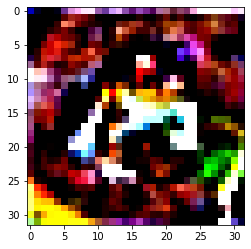

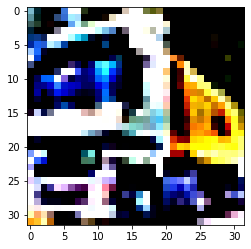

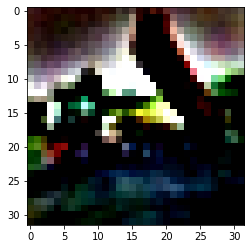

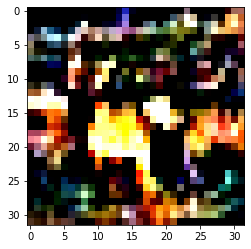

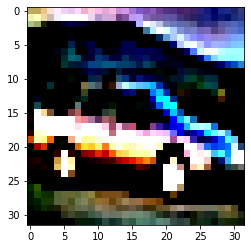

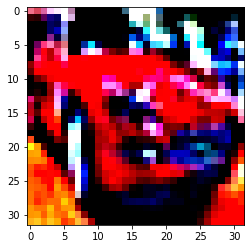

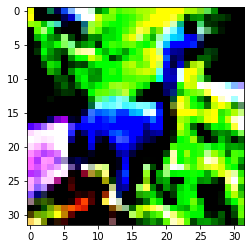

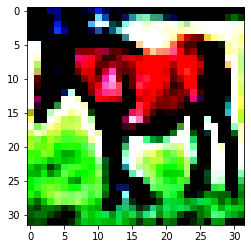

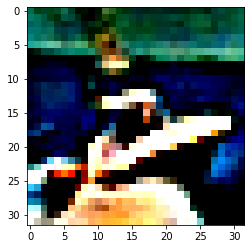

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

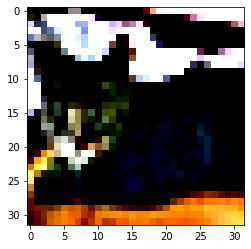

In [319]:
#!g1.1
for i in range(10):
    image = np.transpose(X_train[i], (1,2,0))
    plt.imshow(image)
    plt.show()

In [321]:
#!g1.1
def get_tiny_imagenet_zca(train_dir, test_dir):
    print('getting tiny-imagenet zca:')
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    
    print('loading datasets...')
    
    trainset = datasets.ImageFolder(train_dir, transform=transforms.ToTensor()) 
    testset  = datasets.ImageFolder(test_dir, transform=transforms.ToTensor())
    
    trainloader = utils.data.DataLoader(trainset, pin_memory=True, shuffle=True, batch_size=100000)
    testloader  = utils.data.DataLoader(testset,  pin_memory=True, shuffle=False, batch_size=10000)
    
    _, (X_train, y_train)  = next(enumerate(trainloader))
    _, (X_test,  y_test)   = next(enumerate(testloader))
    
    print('datasets loaded.')
    
    X_train = X_train.numpy().astype(np.float64)
    X_test  = X_test.numpy().astype(np.float64)
    
    print('calculating zca...')
    X_train, X_test = to_zca_faster(X_train, X_test, n_components=3000)
    print('zca_calulated.')
    return torch.tensor(X_train), y_train, torch.tensor(X_test), y_test

TRAIN_DIR = 'tiny-imagenet-200/train'
TEST_DIR  = 'tiny-imagenet-200/val'

X_train_full, labels_train_full, X_test_full, labels_test_full = get_tiny_imagenet_zca(TRAIN_DIR, TEST_DIR)

getting tiny-imagenet zca:
loading datasets...
datasets loaded.
calculating zca...
faster zca
[-0.00336678 -0.00447899 -0.00429362 ... -0.01170834 -0.01263518
 -0.01393276]
calculating svd...
svd calculated. applying svd matricies.
faster zca done.
zca_calulated.


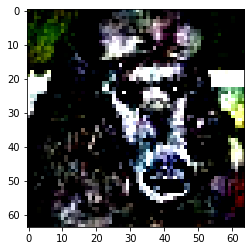

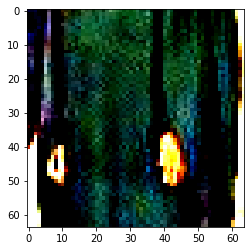

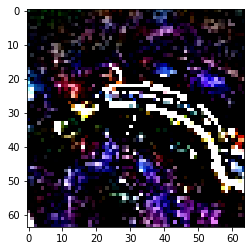

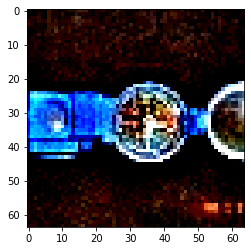

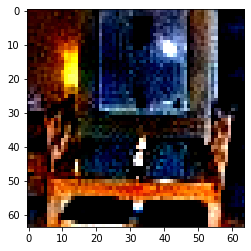

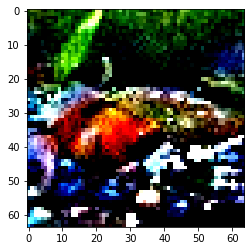

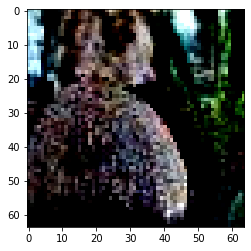

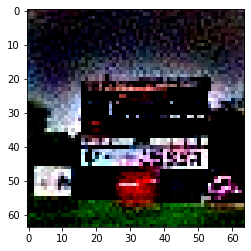

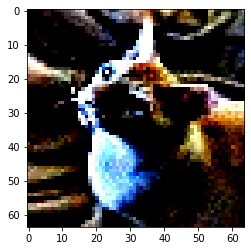

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

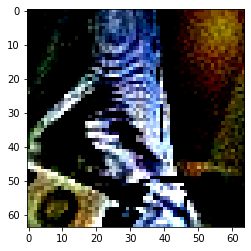

In [322]:
#!g1.1
for i in range(10):
    image = np.transpose(X_train_full[i], (1,2,0))
    plt.imshow(image)
    plt.show()

In [323]:
#!g1.1
from linearized_nns.pytorch_impl.nns.primitives import *

class Myrtle9(nn.Module):
    def __init__(self, num_classes=1, input_filters=3, num_filters=1, groups=1):
        super(Myrtle9, self).__init__()
        filters = num_filters

        def Activation():
            return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters * groups), Activation(),
            Conv(filters, filters * 2, groups),    Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            Conv(filters * 2, filters * 4, groups), Activation(),
            Conv(filters * 4, filters * 8, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            Conv(filters *  8, filters * 16, groups), Activation(),
            Conv(filters * 16, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters *  32, filters * 32, groups), Activation(),
            Conv(filters *  32, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=8, stride=8),

            Flatten(),
            Normalize(filters * 32)
        )
        self.classifier = nn.Linear(filters * 32 * groups, num_classes, bias=True)

    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [403]:
#!g1.1
N_train = 1280 * 5
N_test  = 1000

X_train = X_train_full[:N_train].float()
X_test  = X_test_full[:N_test].float()

In [406]:
#!g1.1
labels_train = labels_train_full[:N_train] 
labels_test  = labels_test_full[:N_test]

y_train = to_one_hot(labels_train, NUM_CLASSES).to(DEVICE)
y_test  = to_one_hot(labels_test,  NUM_CLASSES).to(DEVICE)

In [407]:
#!g1.1
def compute_kernels(models, X_train, X_test):
    with torch.no_grad():
        X_train = X_train.to(DEVICE)
        X_test  = X_test.to(DEVICE)

        n_train = len(X_train)
        n_test  = len(X_test)

        train_kernel = torch.zeros([n_train, n_train]).double().to(DEVICE)
        test_kernel  = torch.zeros([n_test,  n_train]).double().to(DEVICE)

        m = 0
        start_time = time.time()

        for model_i, model in enumerate(models):
            model = model.to(DEVICE)
            if model_i & (model_i - 1) == 0:
                print(f"{model_i} models done. time {time.time() - start_time:.0f}s")

            train_features = model.readout(X_train) 
            test_features  = model.readout(X_test)

            m += 1

            train_kernel += torch.matmul(train_features, train_features.T).double()
            test_kernel  += torch.matmul(test_features,  train_features.T).double()

        train_kernel /= m
        test_kernel  /= m

        return train_kernel.float(), test_kernel.float()

In [408]:
#!g1.1
X_train.shape, X_test.shape

(torch.Size([6400, 3, 64, 64]), torch.Size([1000, 3, 64, 64]))

In [441]:
#!g1.1
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

n_models = 500
models = [Myrtle9(num_filters=1, groups=10) for _ in range(n_models)]

train_kernel, test_kernel = compute_kernels(models, X_train, X_test)

train_kernel = train_kernel.float().cpu()
test_kernel  = test_kernel.float().cpu()

0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 1s
8 models done. time 2s
16 models done. time 3s
32 models done. time 6s
64 models done. time 12s
128 models done. time 24s
256 models done. time 48s


In [442]:
#!g1.1
train_kernel[:5,:5]

tensor([[1.0000, 0.9811, 0.9950, 0.9904, 0.9906],
        [0.9811, 1.0000, 0.9794, 0.9816, 0.9856],
        [0.9950, 0.9794, 1.0000, 0.9915, 0.9882],
        [0.9904, 0.9816, 0.9915, 1.0000, 0.9873],
        [0.9906, 0.9856, 0.9882, 0.9873, 1.0000]])

In [443]:
#!g1.1
test_kernel[:5,:5]

tensor([[0.9857, 0.9794, 0.9850, 0.9844, 0.9855],
        [0.9881, 0.9817, 0.9882, 0.9888, 0.9862],
        [0.9892, 0.9802, 0.9895, 0.9915, 0.9856],
        [0.9870, 0.9795, 0.9864, 0.9883, 0.9836],
        [0.9955, 0.9799, 0.9929, 0.9887, 0.9901]])

In [ ]:
#!g1.1
testloader  = utils.data.DataLoader(testset,  pin_memory=True, shuffle=False, batch_size=10000)
_, (X_test,  y_test)   = next(enumerate(testloader))

In [444]:
#!g1.1
U, D, Ut = randomized_svd(train_kernel.cpu().numpy(), n_components=3000)
print(U.shape, D.shape, Ut.shape)

(6400, 3000) (3000,) (3000, 6400)


In [445]:
#!g1.1
D[1000]

0.003537783

In [446]:
#!g1.1
len(models)

500

In [454]:
#!g1.1

X_train_rf = []
X_train = X_train.to(DEVICE)

for model_i, model in enumerate(models):
    with torch.no_grad():
        torch.cuda.empty_cache() 
        if model_i & (model_i - 1) == 0:
            print(f"{model_i} models done.")
        model = model.to(DEVICE)

        n = len(X_train)
        n_batches = 1
        
        features = model.readout(X_train.to(DEVICE)).cpu()

        X_train_rf.append(features)

X_train_rf = torch.cat(X_train_rf, dim=1)
X_train_rf.shape

0 models done.
1 models done.
2 models done.
4 models done.
8 models done.
16 models done.
32 models done.
64 models done.
128 models done.
256 models done.


torch.Size([6400, 160000])

In [469]:
#!g1.1
U, D, Ut = randomized_svd(train_kernel.cpu().numpy(), n_components=3000)
print(U.shape, D.shape, Ut.shape)

(6400, 3000) (3000,) (3000, 6400)


In [470]:
#!g1.1
U = torch.tensor(U, dtype=torch.float)
U

tensor([[ 1.2529e-02, -8.8133e-03, -3.1044e-03,  ...,  3.4659e-03,
         -2.0382e-02,  6.1604e-02],
        [ 1.2387e-02,  2.5593e-02,  2.2440e-02,  ..., -9.9129e-03,
         -6.3096e-03,  6.2888e-03],
        [ 1.2503e-02, -1.4371e-03,  1.0291e-03,  ..., -2.7229e-02,
         -1.1387e-02, -5.2038e-03],
        ...,
        [ 1.2451e-02,  9.8767e-03,  3.3461e-02,  ..., -5.2140e-05,
          1.5156e-03, -2.2991e-03],
        [ 1.2471e-02,  1.1395e-02, -1.0146e-02,  ..., -7.4768e-03,
          3.5810e-03,  5.5313e-03],
        [ 1.2338e-02,  3.0963e-02, -8.3202e-03,  ..., -6.8407e-03,
          4.5775e-05, -3.4881e-03]])

In [482]:
#!g1.1
V_approx = torch.matmul(U.T, X_train_rf)

In [483]:
#!g1.1
V_approx.shape

torch.Size([3000, 160000])

In [484]:
#!g1.1
norms = V_approx.norm(dim=1)
torch.max(norms), torch.min(norms), norms

(tensor(1779.3932),
 tensor(0.6323),
 tensor([1.7794e+03, 6.9782e+01, 6.2011e+01,  ..., 6.3638e-01, 6.3620e-01,
         6.3536e-01]))

In [485]:
#!g1.1
norms.shape

torch.Size([3000])

In [486]:
#!g1.1
V_approx /= V_approx.norm(dim=1, keepdim=True)

In [487]:
#!g1.1
torch.norm(V_approx, dim=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [488]:
#!g1.1
V_approx.shape

torch.Size([3000, 160000])

In [489]:
#!g1.1
VTV = torch.matmul(V_approx, V_approx.T)
VTV[:10,:10]

tensor([[ 1.0001e+00,  4.4414e-08,  7.5643e-08, -4.0141e-08, -1.3775e-07,
         -3.5948e-07, -2.2380e-07,  6.4961e-07, -7.2315e-07, -5.4613e-07],
        [ 4.4414e-08,  1.0001e+00, -1.7524e-07, -6.5097e-07,  5.2335e-07,
          1.0429e-07,  2.4651e-08,  1.3858e-07, -1.4526e-07,  1.5599e-07],
        [ 7.5643e-08, -1.7524e-07,  1.0001e+00, -1.6147e-06,  1.0774e-06,
          5.2044e-07, -2.2354e-07,  9.8964e-08, -3.4518e-07, -5.5898e-08],
        [-4.0141e-08, -6.5097e-07, -1.6147e-06,  1.0001e+00,  1.3660e-06,
          7.2845e-07, -4.3305e-08,  2.1736e-07, -5.1772e-07, -5.1172e-08],
        [-1.3775e-07,  5.2335e-07,  1.0774e-06,  1.3660e-06,  1.0001e+00,
          4.1659e-07, -3.5610e-07,  2.7534e-07,  1.9137e-07, -5.5164e-08],
        [-3.5948e-07,  1.0429e-07,  5.2044e-07,  7.2845e-07,  4.1659e-07,
          1.0001e+00,  8.5766e-07, -1.6877e-06, -1.1644e-07, -5.2462e-07],
        [-2.2380e-07,  2.4651e-08, -2.2354e-07, -4.3305e-08, -3.5610e-07,
          8.5766e-07,  1.0001e+0

In [490]:
#!g1.1
V = V_approx.T

In [493]:
#!g1.1
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

n_models = 500
models = [Myrtle9(num_filters=1, groups=10) for _ in range(n_models)]

def to_rf(X, models):
    X_rf = []
    X = X.to(DEVICE)

    for model_i, model in enumerate(models):
        with torch.no_grad():
            torch.cuda.empty_cache() 
            if model_i & (model_i - 1) == 0:
                print(f"{model_i} models done.")
            model = model.to(DEVICE)

            features = model.readout(X).cpu()
            X_rf.append(features)
            
    return torch.cat(X_rf, dim=1)

X_test_rf = to_rf(X_test, models)

0 models done.
1 models done.
2 models done.
4 models done.
8 models done.
16 models done.
32 models done.
64 models done.
128 models done.
256 models done.


In [494]:
#!g1.1
V.shape

torch.Size([160000, 3000])

In [613]:
#!g1.1
X_train_ca = torch.matmul(X_train_rf, V).numpy()
X_test_ca  = torch.matmul(X_test_rf, V).numpy()

X_train_ca.shape, X_test_ca.shape

((6400, 3000), (1000, 3000))

In [624]:
#!g1.1
test_set  = datasets.ImageFolder('tiny-imagenet-200/val', transform=transforms.ToTensor())
test_loader  = utils.data.DataLoader(test_set,  pin_memory=True, shuffle=False, batch_size=10000)
_, (_,  labels_test_full_) = next(enumerate(test_loader))

In [626]:
#!g1.1
print('hi')

hi


In [627]:
#!g1.1
labels_train = labels_train_full[:N_train].numpy()
labels_test  = labels_test_full_[:N_test].numpy()

In [628]:
#!g1.1
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train_ca, labels_train)
y_pred = classifier.predict(X_test_ca)
np.average(y_pred == labels_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.165

In [537]:
#!g1.1
X_test_ca.shape, W.shape

(torch.Size([1000, 3000]), torch.Size([3000, 200]))

In [539]:
#!g1.1
X_test_ca.device, W.device

(device(type='cpu'), device(type='cuda', index=0))

In [542]:
#!g1.1
X_test_ca = X_test_ca.clone().to(DEVICE)

RuntimeError: CUDA error: an illegal memory access was encountered

In [546]:
#!g1.1
X_test_ca.numpy().dot(W.clone().cpu().numpy())

RuntimeError: CUDA error: an illegal memory access was encountered

In [527]:
#!g1.1
y_pred = X_test_ca.cpu().numpy().dot(W.cpu().numpy())

RuntimeError: CUDA error: an illegal memory access was encountered

In [509]:
#!g1.1
lr = 1e5

n = len(train_kernel)

exp_term = - lr * compute_exp_term(- lr * train_kernel, DEVICE)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(DEVICE)).float().mean()

tensor(0.0010, device='cuda:0')

In [332]:
#!g1.1
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from linearized_nns.estimator import Estimator
from linearized_nns.pytorch_impl.estimators import SgdEstimator
from linearized_nns.pytorch_impl.nns import Myrtle5, Myrtle7, Myrtle10
from linearized_nns.pytorch_impl import ClassifierTraining
from linearized_nns.pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from linearized_nns.pytorch_impl.nns.utils import to_one_hot, print_sizes
from linearized_nns.from_neural_kernels import to_zca, CustomTensorDataset, get_cifar_zca

In [333]:
#!g1.1
class GpEstimator(Estimator):
    def __init__(self, models, n_classes, learning_rate, x_example, device, groups=1):
        super(GpEstimator, self).__init__()
        self.models    = [model.to(device) for model in models]
        self.lr        = learning_rate
        self.n_classes = n_classes
        self.device    = device
        
        n = len(models)
        X = torch.stack([x_example]).to(self.device)
        
        model = models[0].to(self.device)
        readout_size = model.readout(X).size()[1]
    
        # TODO: Assert that models have the same readout size
        
        self.w      = torch.zeros([n, readout_size, n_classes]).to(self.device)
        self.w_size = n * groups
        
    def get_w_update(self, X, right_vector):
        with torch.no_grad():
            assert len(X) == len(right_vector)

            X            = X.to(self.device)
            right_vector = right_vector.to(self.device)

            n = len(X)
            w_updates = []
            
            for model in self.models:
                features = self.to_model_features(X, model)
                update = torch.matmul(features.T, right_vector)
                w_updates.append(update)
            return torch.stack(w_updates)
                                  
    def to_model_features(self, X, model):
        with torch.no_grad():
            model = model.to(self.device)
            return model.readout(X) * (1. / np.sqrt(self.w_size))
        
    def calc_kernel(self, X):
        with torch.no_grad():
            X = X.to(self.device)
            
            res = torch.zeros([len(X), len(X)]).to(self.device).double()
            for model in self.models:
                features_x = self.to_model_features(X, model)
                
                res += torch.matmul(features_x, features_x.T).double()
            return res.float()
        
    def calc_kernel_pred(self, X):
        with torch.no_grad():
            X = X.to(self.device)
            
            n = len(X)
            y_pred = torch.zeros([n, self.n_classes]).to(self.device).double()
            kernel = torch.zeros([len(X), len(X)]).to(self.device).double()
            
            for model, w in zip(self.models, self.w):
                features = self.to_model_features(X, model)
                
                kernel += torch.matmul(features, features.T).double()
                y_pred += torch.matmul(features, w).double()
            return kernel, y_pred.float()
        
    def calc_kernels(self, X_train, X_test):
        with torch.no_grad():
            X_train = X_train.to(self.device)
            X_test  = X_test.to(self.device)
            
            res_train = torch.zeros([len(X_train), len(X_train)]).to(self.device)
            res_test  = torch.zeros([len(X_test),  len(X_train)]).to(self.device)
            for model in self.models:
                features_train = self.to_model_features(X_train, model)
                features_test  = self.to_model_features(X_test,  model)
                
                res_train += torch.matmul(features_train, features_train.T)
                res_test  += torch.matmul(features_test,  features_train.T)
            return res_train, res_test
            
    def predict(self, X, cur_w=None):
        X = X.to(self.device)
        if cur_w is None:
            cur_w = self.w
         
        with torch.no_grad():
            n = len(X)
            res = torch.zeros([n, self.n_classes]).double().to(self.device)

            for model, w in zip(self.models, cur_w):
                features = self.to_model_features(X, model)
                res += torch.matmul(features, w).double()
            return res.float()

In [334]:
#!g1.1

def calc_right_vector(kernel, y, learning_rate=1e5, reg_param=0):
    with torch.no_grad():
        y      = y.to(DEVICE)
        kernel = kernel.to(DEVICE)
        
        n      = len(kernel)
        reg = torch.eye(n).to(DEVICE) * reg_param
        
        exp_term = - learning_rate * compute_exp_term(- learning_rate * (kernel + reg), DEVICE)
        right_vector = torch.matmul(exp_term, - y)
        return right_vector

In [335]:
#!g1.1

labels_train_full.shape, labels_test_full.shape

(torch.Size([100000]), torch.Size([10000]))

In [336]:
#!g1.1
def boosting(estimator, train_loader, test_loader, learning_rate=1e5, beta=1., noise_rate=0., n_iter=10):
    output_kernel = False
    
    with torch.no_grad():
        batches_num = 0
        for _ in enumerate(train_loader):
            batches_num += 1
        n_batches = (batches_num * 2) // 3 + 1
            
        for iter_num  in range(n_iter):
            print(f"iter {iter_num} ==========================")
            
            w_update = 0
            iter_start = time.time()
            
            for batch_i, (X, y) in enumerate(train_loader):
                if batch_i >= n_batches:
                    break
                
                X = X.to(DEVICE)
                y = y.to(DEVICE)
                
                kernel, y_pred = estimator.calc_kernel_pred(X)
                if output_kernel:
                    print(f"kernel\n{kernel[:5,:5]}")
                
                y_residual = y_pred - y
                
                train_acc = (y_pred.argmax(dim=1) == y.argmax(dim=1)).float().mean().item()
                train_mse = (y_residual ** 2).mean().item()
                print(f"batch {batch_i}: train_acc {train_acc:.4f}, train_mse {train_mse:.6f}")
                
                right_vector = calc_right_vector(kernel, y_residual, learning_rate=learning_rate)
                
                w_update += estimator.get_w_update(X, right_vector).double()
                
                pred_change = torch.matmul(kernel, right_vector.double())
                

            w_update = (w_update / n_batches).float()
            
            _, (X, y) = next(enumerate(train_loader))
            y = y.to(DEVICE)
            
            y_pred      = estimator.predict(X)
            pred_change = estimator.predict(X, w_update)
            
            y_residual = (y_pred - y)
            
            w_std = w_update.std()
            noise = w_std * torch.randn(w_update.size()).to(DEVICE)
            estimator.w -= (w_update + noise_rate * noise) * beta 
            
            test_acc = 0
            for i, (X_test, labels) in enumerate(test_loader):
                y_pred = estimator.predict(X_test) 
                cur_acc   = (y_pred.argmax(dim=1) == labels.to(DEVICE)).float().mean().item()
                test_acc += (cur_acc - test_acc) / (i + 1)
                
            print(f"iter {iter_num} done. took {time.time() - iter_start:.0f}s. beta {beta:.3f}, test_acc {test_acc:.4f}")
            print()

In [337]:
#!g1.1
train_set = CustomTensorDataset(X_train_full, to_one_hot(labels_train_full, NUM_CLASSES))
test_set  = CustomTensorDataset(X_test_full,  labels_test_full)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1280 * 4)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=2000)

In [339]:
#!g1.1

%state_exclude estimator
%state_exclude models

torch.manual_seed(0)
np.random.seed(0)

n_models = 1024
models = [Myrtle9(num_filters=1, groups=10) for _ in range(n_models)]

estimator = GpEstimator(models, NUM_CLASSES, 0.2, X_train[0], DEVICE, groups=10)
boosting(estimator, train_loader, test_loader, learning_rate=1e5, n_iter=30)

iter 0 ==========================
batch 0: train_acc 0.0061, train_mse 1.000000
batch 1: train_acc 0.0035, train_mse 1.000000
batch 2: train_acc 0.0047, train_mse 1.000000
batch 3: train_acc 0.0041, train_mse 1.000000
batch 4: train_acc 0.0057, train_mse 1.000000
batch 5: train_acc 0.0049, train_mse 1.000000
batch 6: train_acc 0.0035, train_mse 1.000000
batch 7: train_acc 0.0051, train_mse 1.000000
batch 8: train_acc 0.0066, train_mse 1.000000
batch 9: train_acc 0.0043, train_mse 1.000000
batch 10: train_acc 0.0055, train_mse 1.000000
batch 11: train_acc 0.0057, train_mse 1.000000
batch 12: train_acc 0.0045, train_mse 1.000000
batch 13: train_acc 0.0055, train_mse 1.000000
iter 0 done. took 4225s. beta 1.000, test_acc 0.3693

iter 1 ==========================
batch 0: train_acc 0.9031, train_mse 0.016044
batch 1: train_acc 0.8957, train_mse 0.016068
batch 2: train_acc 0.9029, train_mse 0.016093
batch 3: train_acc 0.9027, train_mse 0.016003
batch 4: train_acc 0.9002, train_mse 0.016085


In [341]:
#!g1.1
X_train_full.shape

torch.Size([100000, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


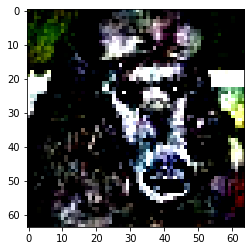

In [342]:
#!L
plt.imshow(X_train_full[0].permute(1,2,0).cpu().numpy())

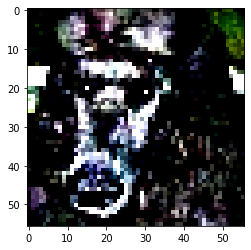

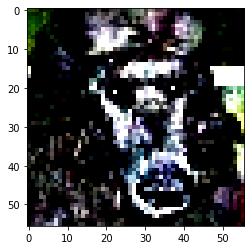

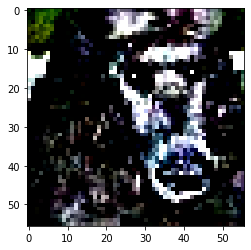

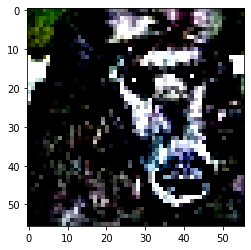

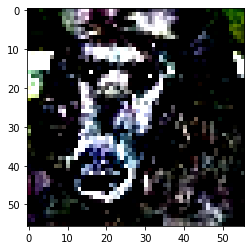

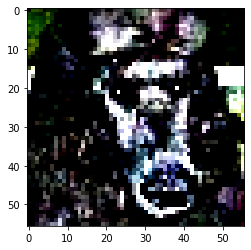

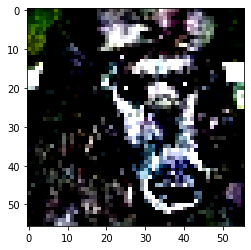

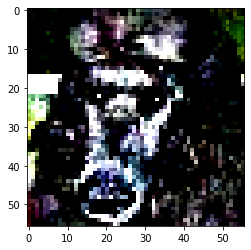

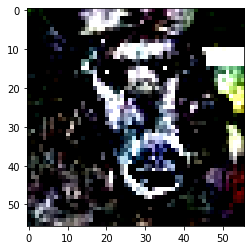

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

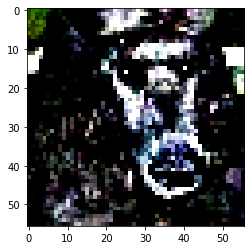

In [370]:
#!L
from torchvision import transforms
from torch.utils.data import Dataset

from linearized_nns.from_neural_kernels.transforms import RandomCrop

class TrainTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    randomcrop = RandomCrop(56, padding=0)

    def __init__(self, data, targets):
        assert data.size(0) == targets.size(0)
        self.data = data
        self.targets = targets

    def __getitem__(self, idx):
        x = self.data[idx]
        x = self.augment_x(x)

        y = self.targets[idx]
        return x, y

    def __len__(self):
        return self.data.size(0)

    def augment_x(self, x, transform='all'):
        x = self.randomcrop(x)
        if np.random.binomial(1, 0.5) == 1:
            x = x.flip(2)
        return x.float()

smalldataset = TrainTensorDataset(X_train_full[:1], to_one_hot(labels_train_full[:1], NUM_CLASSES))


small_loader = DataLoader(smalldataset, batch_size=1)
for _ in range(10):
    _, (x, _) = next(enumerate(small_loader))
    plt.imshow(x[0].permute(1,2,0).cpu().numpy())
    plt.show()

In [372]:
#!L
import numbers
import numpy as np
import random
import torch

class CenterCrop(object):
    def __init__(self, size, padding=None, pad_if_needed=False, fill=0,padding_mode='constant'):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    @staticmethod
    def get_params(img, output_size):
        h, w = img.shape[1], img.shape[2]
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w
        i = (h - th) // 2
        j = (w - tw) // 2
        return i, j, th, tw

    def __call__(self, img):
        device = img.device
        dtype = img.dtype
        img = img.detach().cpu().numpy()
        if self.padding is not None:
            img = np.transpose(img, (1, 2, 0))
            temp = np.zeros((img.shape[0]+2*self.padding, img.shape[1]+2*self.padding, img.shape[2]))
            # img = np.pad(img, self.padding, self.padding_mode, constant_values=self.fill)
            temp[self.padding: self.padding+img.shape[0], self.padding: self.padding+img.shape[1], :] = img
            img = temp
            img = np.transpose(img, (2, 0, 1))
        i, j, h, w = self.get_params(img, self.size)
        img =  img[:, i:i+h, j:j+w]
        img = torch.Tensor(img).to(dtype=dtype, device=device)
        return img

    def __repr__(self):
        return self.__class__.__name__ + '(size={0}, padding={1})'.format(self.size, self.padding)

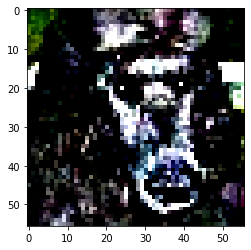

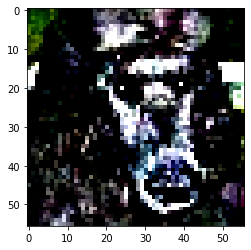

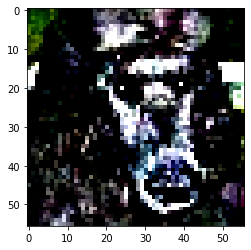

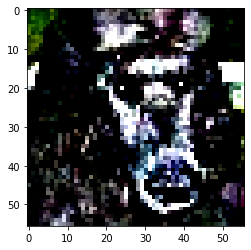

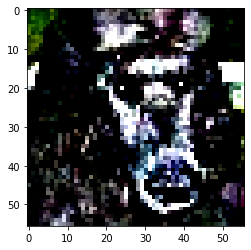

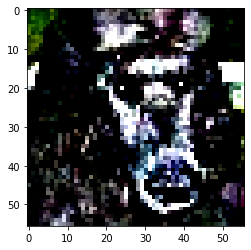

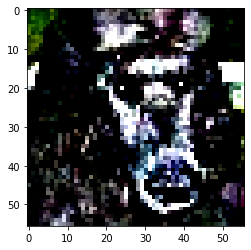

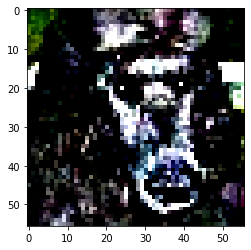

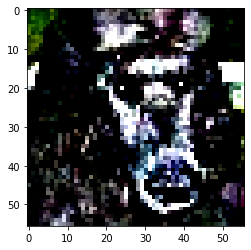

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

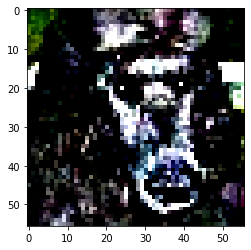

In [374]:
#!L


class TestTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    centercrop = CenterCrop(56, padding=0)

    def __init__(self, data, targets):
        assert data.size(0) == targets.size(0)
        self.data = data
        self.targets = targets

    def __getitem__(self, idx):
        x = self.data[idx]
        x = self.augment_x(x)

        y = self.targets[idx]
        return x, y

    def __len__(self):
        return self.data.size(0)

    def augment_x(self, x, transform='all'):
        x = self.centercrop(x)
        return x.float()
    
    
smalldataset = TestTensorDataset(X_train_full[:1], to_one_hot(labels_train_full[:1], NUM_CLASSES))

small_loader = DataLoader(smalldataset, batch_size=1)
for _ in range(10):
    _, (x, _) = next(enumerate(small_loader))
    plt.imshow(x[0].permute(1,2,0).cpu().numpy())
    plt.show()

In [375]:
#!L
train_set = TrainTensorDataset(X_train_full, to_one_hot(labels_train_full, NUM_CLASSES))
test_set  = TestTensorDataset(X_test_full,  labels_test_full)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1280 * 4)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=2000)

In [377]:
#!L
class Myrtle9(nn.Module):
    def __init__(self, num_classes=1, input_filters=3, num_filters=1, groups=1):
        super(Myrtle9, self).__init__()
        filters = num_filters

        def Activation():
            return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters * groups), Activation(),
            Conv(filters, filters * 2, groups),    Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            Conv(filters * 2, filters * 4, groups), Activation(),
            Conv(filters * 4, filters * 8, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            Conv(filters *  8, filters * 16, groups), Activation(),
            Conv(filters * 16, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters *  32, filters * 32, groups), Activation(),
            Conv(filters *  32, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=7, stride=7),

            Flatten(),
            Normalize(filters * 32)
        )
        self.classifier = nn.Linear(filters * 32 * groups, num_classes, bias=True)

    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [380]:
#!L
%state_exclude estimator
%state_exclude models

torch.manual_seed(0)
np.random.seed(0)

n_models = 1024
models = [Myrtle9(num_filters=1, groups=10) for _ in range(n_models)]

estimator = GpEstimator(models, NUM_CLASSES, 0.2, X_train[0], DEVICE, groups=10)
boosting(estimator, train_loader, test_loader, learning_rate=1e5, n_iter=30)

iter 0 ==========================
batch 0: train_acc 0.0061, train_mse 1.000000
batch 1: train_acc 0.0035, train_mse 1.000000
batch 2: train_acc 0.0047, train_mse 1.000000
batch 3: train_acc 0.0041, train_mse 1.000000
batch 4: train_acc 0.0057, train_mse 1.000000
batch 5: train_acc 0.0049, train_mse 1.000000
batch 6: train_acc 0.0035, train_mse 1.000000
batch 7: train_acc 0.0051, train_mse 1.000000
batch 8: train_acc 0.0066, train_mse 1.000000
batch 9: train_acc 0.0043, train_mse 1.000000
batch 10: train_acc 0.0055, train_mse 1.000000
batch 11: train_acc 0.0057, train_mse 1.000000
batch 12: train_acc 0.0045, train_mse 1.000000
batch 13: train_acc 0.0055, train_mse 1.000000
iter 0 done. took 3295s. beta 1.000, test_acc 0.3439

iter 1 ==========================
batch 0: train_acc 0.5176, train_mse 0.017862
batch 1: train_acc 0.5205, train_mse 0.017869
batch 2: train_acc 0.5195, train_mse 0.017872
batch 3: train_acc 0.5289, train_mse 0.017773
batch 4: train_acc 0.5236, train_mse 0.017854
